# Data Challenge

Peiwen Zhao


# Part 1 Data Munging

### Import python library

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

import missingno as msno

from IPython.display import Image

from matplotlib.colors import LinearSegmentedColormap

from sklearn.neighbors import LocalOutlierFactor

### a. Merge data

Here I have created a ''Loan_bucket'' attribute to bucket the loan amount into 4 equal size groups, each containing 25% of the loan volume:

In [2]:
institution_data = pd.read_csv('2012_to_2014_institutions_data.csv')
loan_data = pd.read_csv('2012_to_2014_loans_data.csv')
final_data = loan_data.merge(institution_data, how = 'left', on = ['As_of_Year','Respondent_ID','Agency_Code'])

C:\Users\zhaop\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (3,4,5,7,8,9,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
final_data['Loan_bucket'] = pd.qcut(final_data['Loan_Amount_000'], 4, labels=['0-25%', '25%-50%', '50%-75%', '75%-100%'])

pd.DataFrame(final_data.groupby('Loan_bucket', as_index = False)\
             .agg({'Loan_Amount_000': {'Median': np.median, 'Count':'count'}})
             .rename(index=str, columns={'Loan_Amount_000': 'Bucket Loan Amount Summary'}))

C:\Users\zhaop\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


Loan_bucket Bucket Loan Amount Summary        
                                  Median   Count
0       0-25%                      110.0  331245
1     25%-50%                      194.0  333064
2     50%-75%                      283.5  326870
3    75%-100%                      417.0  329979

In [4]:
# print out merging report
print ('Let us check the size of the dataset:')
print ('')
print ("There are {0} records and {1} columns in loan dataset."\
       .format(loan_data.shape[0],loan_data.shape[1]))
print ("There are {0} records and {1} columns in institution dataset."\
       .format(institution_data.shape[0],institution_data.shape[1]))
print ("There are {0} records and {1} columns in merged dataset."\
       .format(final_data.shape[0],final_data.shape[1]))

Let us check the size of the dataset:

There are 1321158 records and 24 columns in loan dataset.
There are 21655 records and 12 columns in institution dataset.
There are 1321158 records and 34 columns in merged dataset.


### b. Provide a simple API of two functions

- **hmda_init()** – Reading the data files and returning a pointer or object containing the expanded HMDA data from part a

In [5]:
def hdma_init(loan_fname,insitution_fname):
    institution_data = pd.read_csv(insitution_fname,low_memory=False)
    loan_data = pd.read_csv(loan_fname,low_memory=False)
    final_data = loan_data.merge(institution_data, how = 'left', on = ['As_of_Year','Respondent_ID','Agency_Code'])
    final_data['Loan_binned'] = pd.qcut(final_data['Loan_Amount_000'], 4, labels=['0-25%', '25%-50%', '50%-75%', '75%-100%'])
    
    # print out merging report
    print ('Data merged successfully! Let use check the size of the datasize:')
    print ('')
    print ("There are {0} records and {1} columns in loan dataset."\
       .format(loan_data.shape[0],loan_data.shape[1]))
    print ("There are {0} records and {1} columns in institution dataset."\
       .format(institution_data.shape[0],institution_data.shape[1]))
    print ("There are {0} records and {1} columns in merged dataset."\
       .format(final_data.shape[0],final_data.shape[1]))
    
    return final_data

Code for testing hdma_init():

In [6]:
#hdma_init('2012_to_2014_loans_data.csv','2012_to_2014_institutions_data.csv')

- **hmda_to_json(data, states, conventional_conforming)** – Exporting the expanded data set to disk for the states filtered by product segment. 

In [7]:
def hdma_to_json(data,states = [], conventional_conforming = "NA"):
    states = list(map(lambda x: x.upper(),states))
    conventional_conforming = conventional_conforming.upper()
    if len(states) == 0:
        states = data.State.unique()
    filtered_state = final_data.loc[final_data.State.isin(states),:]
    if conventional_conforming == "NA":
        filtered_final = filtered_state
    else:
        filtered_final = filtered_state.loc[filtered_state.loc[:,'Conventional_Conforming_Flag'] == conventional_conforming,:]
        
    # print exporting report
    print ('Data exported to disk as json file successfully!')
    print ('')
    print ("{0} records was stored in hdma.json".format(filtered_final.shape[0]))
    
    
    filtered_final.to_json("hdma.json")

Code for testing hdma_to_json():

In [8]:
#hdma_to_json(final_data,['VA'],'N')

# Part 2 Quality check 

### Criteria
**I will follow 5 Data Quality Dimensions to check the dataset at hand and recommend the data team to follow similar practice in the future:**

   
 - **Conformity:** Data values should conform to specified formats. Maintaining conformance is important in data representation, presentation, aggregate reporting, and establishing key relationships.
 - **Consistency:** Consistency of value across datasets.
 - **Accuracy:** Value should reflect the truth and be recorded without mistake.
 - ** Validity:** Value should conform to a preset standard. For recording loan information, values are expected to conform to business rule and domain of predefined values. 
 - ** Completeness:** If large proportion of data is missing or data is missing not at random, it would not be ideal to use existing data to represent the whole population and perform analysis. 

## a1. Quality check for 'Loan_Amount_000'

Let us look at the summary of loan amount. This attribute has no missing values, however the maximum loan is 99625k, which is extremely high and could be a recording error or outlier.

In [9]:
final_data['Loan_Amount_000'].describe().apply(lambda x: format(x, '.2f'))

count    1321158.00
mean         290.23
std          965.78
min            1.00
25%          153.00
50%          235.00
75%          347.00
max        99625.00
Name: Loan_Amount_000, dtype: object

Below is the distribution density plot of loan amount. As the distribution is highly right skewed, I choose to only plot loan amount in the range of 0-1000 to get a more clear graph.

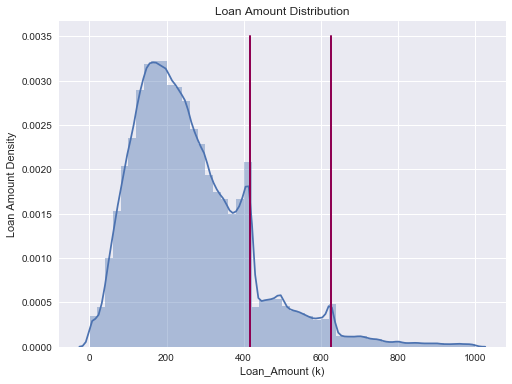

In [10]:
plt.figure(figsize=(8,6))
ax = sns.distplot(final_data['Loan_Amount_000'][final_data['Loan_Amount_000']<1000])#,color = '#4d9221')
ax.set(xlabel='Loan_Amount (k)', ylabel='Loan Amount Density',title = 'Loan Amount Distribution')
plt.plot([417, 417], [0.0035, 0], linewidth=2,color = '#8e0152')
plt.plot([625.5, 625.5], [0.0035, 0], linewidth=2,color = '#8e0152')
plt.show() 

From the plot we can see there are two clear peaks of loan volume when loan value is near 625k and 417k. It might be related to Conforming Limits attribute.

In [11]:
final_data[['Conforming_Limit_000','Loan_Amount_000']]\
            .groupby('Conforming_Limit_000',as_index = False)\
            .count().sort_values('Loan_Amount_000',ascending = False)\
            .rename(index=str, columns={'Loan_Amount_000': 'Count'})

,Conforming_Limit_000,Count
6,625.0,574645
0,417.0,289854
4,494.0,206954
3,458.0,133229
5,535.0,99990
1,437.0,15106
2,442.0,543


Maximum Loan Limits for 1-unit in most records are 417k and 625k in year 2013, which might be the reason for the peaks.           The Maximum Loan Limit for 4-units is 801.95k (obtained from https://www.fhfa.gov/DataTools/Downloads/pages/conforming-loan-limits.aspx), giving me an idea about the reasonable loan value upper limit.

Let's dig deeper for further insights on the extreme loans > 801.95k.

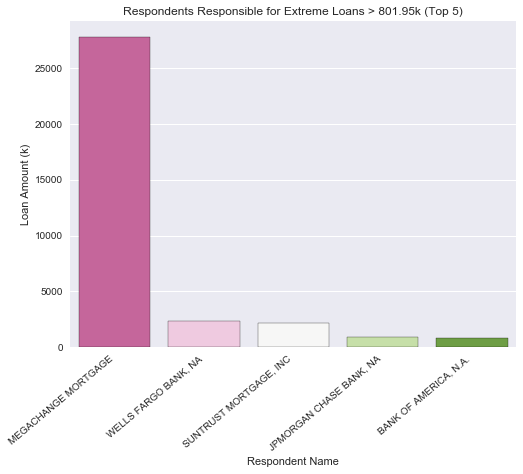

In [12]:
extreme_loan = final_data[['Loan_Amount_000','Respondent_Name_TS']][final_data['Loan_Amount_000']>801.95]\
                .groupby('Respondent_Name_TS',as_index = False).sum()\
                .sort_values(by=['Loan_Amount_000'],ascending=False) \
                .head(20)
extreme_loan['Loan_Amount_000'] = extreme_loan['Loan_Amount_000']/1000

megachange = final_data[['Loan_Amount_000','Applicant_Income_000','Respondent_Name_TS']]\
                    [final_data['Respondent_Name_TS']=='MEGACHANGE MORTGAGE']
            
plt.figure(figsize=(8,6))
ax = sns.barplot(x='Respondent_Name_TS', y='Loan_Amount_000',palette="PiYG",data=extreme_loan[0:5],edgecolor='black')
ax.set(xlabel='Respondent Name', ylabel='Loan Amount (k)',title = 'Respondents Responsible for Extreme Loans > 801.95k (Top 5)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

The above plot shows that Megachange Mortage accounts for most of these extreme loans.

Now let us look at the relationship between loan amount and applicant income.

In [13]:
# Clean the NAs in the columns
final_data['Applicant_Income_000']= pd.core.strings.str_strip(final_data['Applicant_Income_000'])


final_data[['Applicant_Income_000']]\
            = final_data[['Applicant_Income_000']].replace('NA',np.NaN)
final_data[['Applicant_Income_000']]\
            = final_data[['Applicant_Income_000']]\
            .apply(pd.to_numeric, errors='ignore')

C:\Users\zhaop\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


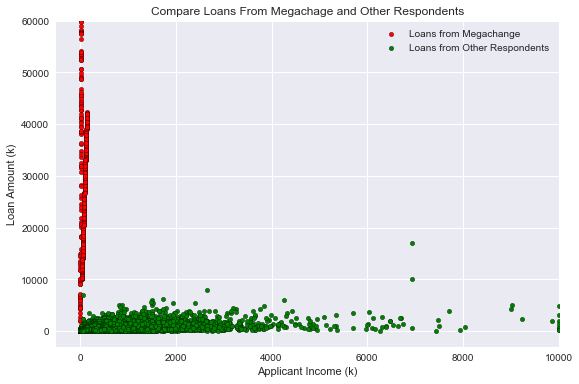

In [14]:
megachange = final_data[['Loan_Amount_000','Applicant_Income_000','Respondent_Name_TS']]\
                    [final_data['Loan_Amount_000']>801.95]\
                    [final_data['Respondent_Name_TS']=='MEGACHANGE MORTGAGE']
        
other = final_data[['Loan_Amount_000','Applicant_Income_000','Respondent_Name_TS']]\
    [final_data['Respondent_Name_TS']!='MEGACHANGE MORTGAGE']#\

plt.figure(figsize=(9,6))
a = plt.scatter(x='Applicant_Income_000', y='Loan_Amount_000',data=megachange,color = 'red',edgecolor='k', s=20)

b = plt.scatter(x='Applicant_Income_000', y='Loan_Amount_000',data=other,color = 'green',edgecolor='k', s=20)

plt.xlabel('Applicant Income (k)')
plt.ylabel('Loan Amount (k)')
plt.title('Compare Loans From Megachage and Other Respondents')
            
plt.xlim((-500, 10000))
plt.ylim((-3000, 60000))
plt.legend([a, b],
           ["Loans from Megachange",
            "Loans from Other Respondents"],
           loc="upper right")

plt.show()

In [15]:
L_I_Megachange = final_data[final_data['Respondent_Name_TS']=='MEGACHANGE MORTGAGE'][final_data['Loan_Amount_000']>801.95]
L_I_Megachange = round((L_I_Megachange['Loan_Amount_000']/L_I_Megachange['Applicant_Income_000']).median(),2)#.round(2)

L_I_Ex = final_data[final_data['Respondent_Name_TS']!='MEGACHANGE MORTGAGE'][final_data['Loan_Amount_000']>801.95]
L_I_Ex = round((L_I_Ex['Loan_Amount_000']/L_I_Ex['Applicant_Income_000']).median(),2)

L_I_Normal = final_data[final_data['Loan_Amount_000']<801.95]
L_I_Normal = round((L_I_Normal['Loan_Amount_000']/L_I_Normal['Applicant_Income_000']).median(),2)

print ("Average Loan to Income Ratio of Megachange is {0}, average Loan to Income Ratio of all extreme loans is {1}, whereas average Loan to Income Ratio of normal loans is {2}"\
       .format(L_I_Megachange,L_I_Ex,L_I_Normal))

C:\Users\zhaop\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\zhaop\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


Average Loan to Income Ratio of Megachange is 302.43, average Loan to Income Ratio of all extreme loans is 2.97, whereas average Loan to Income Ratio of normal loans is 2.55


The scatter plot compares how Loan to Income ratio is different for Megachange Mortgage as compared to other respondents.

It is clear that the loan amount Megachange Mortgage provides is very high at 302.43. 

Irrespective of the source of Merchant Mortgage information, they need to be flagged and highlighted as a part of data quality checking process. Additional information would be useful in making conclusion if this was a system/data entry error or there were actual loans provided.

### Technique to identify extreme loan amounts: 

Anomaly detection with Local Outlier Factor (LOF) Algorithm 

The LOF algorithm is an unsupervised outlier detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outlier the samples that have a substantially lower density than their neighbors.

Reference: https://turi.com/learn/userguide/anomaly_detection/local_outlier_factor.html

Here I will extract random sample data of 'Applicant_Income_000','Loan_Amount_000' column from the dataset to show the performance of LOF on outlier detection.

C:\Users\zhaop\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


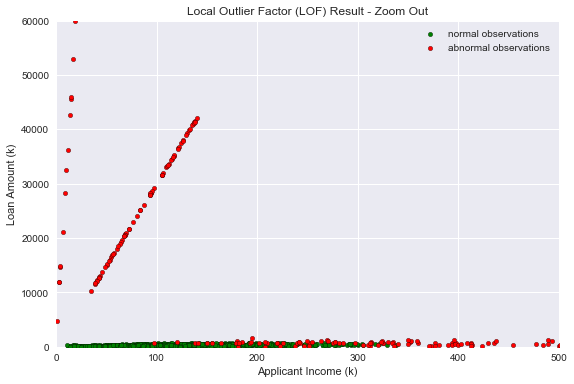

In [16]:
# Generate train data
X = final_data[['Applicant_Income_000','Loan_Amount_000']][final_data['Applicant_Income_000'].notnull()].sample(2000).values
# Generate some abnormal observations
X_outliers = final_data[final_data['Respondent_Name_TS']=='MEGACHANGE MORTGAGE'][final_data['Applicant_Income_000'].notnull()]\
            [['Applicant_Income_000','Loan_Amount_000']].sample(100).values
X = np.r_[X, X_outliers]

# fit the model
clf = LocalOutlierFactor(n_neighbors=500)
y_pred = clf.fit_predict(X)

# Plot
plt.figure(figsize=(9,6))

a = plt.scatter(X[y_pred>0, 0], X[y_pred>0, 1], c='green',edgecolor='k', s=20)
b = plt.scatter(X[y_pred<0, 0], X[y_pred<0, 1], c='red', edgecolor='k', s=20)

plt.xlim((-0, 500))
plt.ylim((0, 60000))
plt.legend([a, b],
           ["normal observations",
            "abnormal observations"],
           loc="upper right")

plt.xlabel('Applicant Income (k)')
plt.ylabel('Loan Amount (k)')
plt.title("Local Outlier Factor (LOF) Result - Zoom Out")

plt.show()

If we zoom out to show all the points, we can easily spot that LOF algorithm is able to capture almost all the extreme loans from Megachange.

Let us zoom in to see loans from respondents other than Megachange

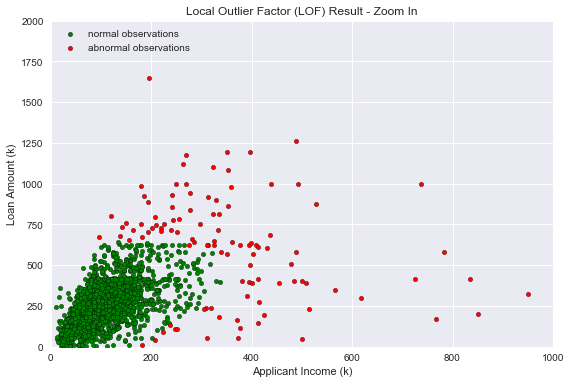

In [17]:
plt.figure(figsize=(9,6))
plt.title("Local Outlier Factor (LOF) Result - Zoom In")

a = plt.scatter(X[y_pred>0, 0], X[y_pred>0, 1], c='green',
                edgecolor='k', s=20)
b = plt.scatter(X[y_pred<0, 0], X[y_pred<0, 1], c='red',
                edgecolor='k', s=20)

plt.xlim((-0, 1000))
plt.ylim((0, 2000))
plt.legend([a, b],
           ["normal observations",
            "abnormal observations"],
           loc="upper left")

plt.xlabel('Applicant Income (k)')
plt.ylabel('Loan Amount (k)')
plt.title("Local Outlier Factor (LOF) Result - Zoom In")

plt.show()

In the above plot, I changed the x-axis and y-axis limit to show points from respondents other than Megachange. The algorithm successfully identified most of the loans with high loan value but relatively low income.

Going forward, the data team will be able to scale the outlier detection process to the whole dataset and flag all extreme loans as a part of the data quality checking process. Further investigations can then be conducted on these loans.

## a2. Quality check for 'Respondent_Name'

For the 'Respondent_Name_TS' column, I leveraged string matching technique using 'fuzzywuzzy' package to identify potential data entry errors in this field. 

In future, if the data team needs to manully check some specific respondent name, they can do it by simpily entering the name in the below textbox.

In [18]:
choices = institution_data['Respondent_Name_TS'].unique().tolist()

def f2(name_entered):
    result = pd.DataFrame(process.extract(name_entered, choices, limit=5),\
                          columns = ['Respondent_Name','Matching Score'])
    display(result)
    
w = interact(f2,name_entered=widgets.Text(value='FIRST FINANCIAL BANK',\
                placeholder='Type something',description='Enter Respondent Name:'))

We can notice that there are several problems:

- The respondent names are not **consistent** throughout the years. For example: 
    - The same respondent 'First Finanacial Bank' is recorded as both 'FIRST FINANCIAL BANK NA' and 'FIRST FINANCIAL BANK N.A.' in different years;
    - The same respondent 'The First National Bank of Groton' is recorded as both 'THE FIRST NATL BANK OF GROTON' and 'THE FIRST NATIONAL BANK OF GROTON' in different years.
    - Further inconsistencies can be observed such as
        - 'NA', 'N.A.'
        - Comma, dot and special characters 
        - 'The' 
        - 'CO', 'COMP' representing term 'company'
    
Such inconsistancies cause problems while performing aggregation and analysis on the respondent level.  

### Approach:
I propose two approaches to tackle this problem:

- Align the respondent spelling of year 2012 and 2013 to that of year 2014 to make sure that respondent name under the same respondent ID remains consistent across the years
- Further, I remove all special characters such as symbols, commas, and dot from the column to capture only the key information

### Define function for quality check on 'Respondent_Name' attribute:

In [19]:
def QC_Respondent_Name(dataset):
    
    global final_data
    # create a copy for the column
    final_data = dataset.copy()
    final_data['Respondent_Name_CR1']=final_data['Respondent_Name_TS']
    
    # Remove or replace all symbols
    lst = [',', '.', 'CO', '&', 'CO', 'COMP', 'THE', 'AND', ' NA']
    for item in lst:
        final_data['Respondent_Name_CR1']=final_data['Respondent_Name_CR1'].str.replace(item,'')

    # Align the spelling in year 2012, 2013, 2014
    respondent_real_name_data = final_data.\
                            sort_values(by=["Respondent_ID","As_of_Year"]).\
                            groupby("Respondent_ID").tail(1).\
                            loc[:,["Respondent_ID","Respondent_Name_CR1"]]
                
    respondent_real_name_data=respondent_real_name_data.rename(index=str, columns={"Respondent_Name_CR1": "Respondent_Name_CR"})
    final_data = final_data.merge(respondent_real_name_data, how = 'left', on = ['Respondent_ID'])
    final_data = final_data.drop(['Respondent_Name_CR1'],axis=1)
    
    print ('Respondent Name quality check finished!')

In [20]:
QC_Respondent_Name(final_data)

Respondent Name quality check finished!


## b. Quality check for two additional column

### b1. Quality check for 'Zipcode' column:
I believe that decisions are taken at a zipcode level for everyday operations and hence quality check at a zipcode level is crucial.  

I find that for zipcode, the same address is recorded as 5-digits format as well as 9-digits format (for example 55114 and 55114-6594). This inconsistency might cause error in the future when the data needs to be aggregated by zipcode. 
 
To rectify this, I will create one extra column to store 'plus-4 code'.

In [21]:
def QC_Zip_Code(dataset):
    
    global final_data
    final_data[['Respondent_ZIP_Code','Respondent_plus_four_ZIP_Code']] = \
        dataset['Respondent_ZIP_Code'].str.split('-',1,expand=True)
    
    
    final_data[['Parent_ZIP_Code','Parent_plus_four_ZIP_Code']] = \
        final_data['Parent_ZIP_Code'].str.split('-',1,expand=True)

In [22]:
QC_Zip_Code(final_data)

### b2. Quality check for 'Applicant_Income_000' column:
As applicant income level reflects the risk associated with the loan, hence I would perform similar quality check for 'Applicant_Income_000' as I did for 'Loan_Amount_000'.

Below are the data summary and distribution plot

In [23]:
final_data['Applicant_Income_000'].describe().apply(lambda x: format(x, '.2f'))

count    1203305.00
mean         118.02
std          122.70
min            0.00
25%           60.00
50%           94.00
75%          142.00
max         9999.00
Name: Applicant_Income_000, dtype: object

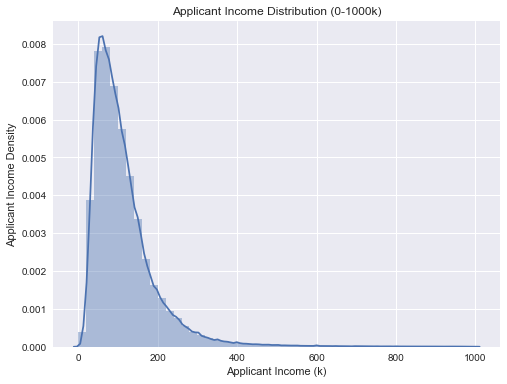

In [24]:
plt.figure(figsize=(8,6))
ax = sns.distplot(final_data['Applicant_Income_000'][final_data['Applicant_Income_000']<1000])
ax.set(xlabel='Applicant Income (k)', ylabel='Applicant Income Density',title = 'Applicant Income Distribution (0-1000k)')
plt.show() 

Similarly, there are extreme values and ~10% missing values in this attribute. 

Based on information at hand I can not identify the reason for extreme value (as extreme salary may exist in reality), but I would perform outlier detection on this attribute and flag extreme value to report to the strategy team.

## c. Concerns & recommendation for data quality

### c1 Data Conformity check for the whole dataset through an automated function

In [25]:
final_data.dtypes

Agency_Code                          int64
Applicant_Income_000               float64
As_of_Year                           int64
Census_Tract_Number                 object
County_Code                         object
FFIEC_Median_Family_Income          object
Loan_Amount_000                      int64
MSA_MD                              object
Number_of_Owner_Occupied_Units      object
Respondent_ID                       object
Sequence_Number                      int64
State_Code                           int64
Tract_to_MSA_MD_Income_Pct          object
MSA_MD_Description                  object
Loan_Purpose_Description            object
Agency_Code_Description             object
Lien_Status_Description             object
Loan_Type_Description               object
State                               object
County_Name                         object
Conforming_Limit_000               float64
Conventional_Status                 object
Conforming_Status                   object
Conventiona

We can see that 'MSA_MD' and 'Number_of_Owner_Occupied_Units' columns should be numeric in type. However, missing values recorded as 'NA ' make these columns being recognized as string type in python. 
(Similar error happens on 'Applicant_Income_000', 'FFIEC_Median_Family_Income' and 'Tract_to_MSA_MD_Income_Pct' column, but we have already corrected them in Part1.a and Part1.b)

I would suggest a function to check data Conformity for the whole dataset at once at the begining to save manual effort on checking for each individual column and to establish automated data quality check as a best practice.

#### Define function for quality check on Data Conformity:

In [26]:
def df_convert(df):
    global final_data
    # Loop for each column
    for c in ['Applicant_Income_000','FFIEC_Median_Family_Income',\
           'MSA_MD','Number_of_Owner_Occupied_Units','Tract_to_MSA_MD_Income_Pct']:
        
        if df[c].dtype == np.object:
            # remove extra space in each cell.
            df[c] = pd.core.strings.str_strip(df[c])
            
            # Convert record = 'NA' to python standart missing vaule format
            df[c] = df[c].replace('^NA$', np.nan, regex=True)

    # Covert string to numeric type if the column does not contain any letter
    final_data[['Applicant_Income_000','FFIEC_Median_Family_Income',\
           'MSA_MD','Number_of_Owner_Occupied_Units','Tract_to_MSA_MD_Income_Pct']]\
            = df[['Applicant_Income_000','FFIEC_Median_Family_Income',\
            'MSA_MD','Number_of_Owner_Occupied_Units','Tract_to_MSA_MD_Income_Pct']]\
            .apply(pd.to_numeric, errors='ignore')

In [27]:
df_convert(final_data)

### c2. Provide Data Completeness and Validity report for strategy team in the future practice

To monitor data quality, I would suggest an auto reporting system to inform the strategy team the completeness of data and whether the value conforms to rules. For example:

- Flag column validity report: 'Conventional_Conforming_Flag' column requested to be 'Y' if Conventional_Status is "Conventional" and "Conforming_Status" is "Conforming". 
- Missing value proportion report

    Conventional_Conforming_Flag Attribute Validity Check Report
                                                                         0
Conventional_Status Conforming_Status Conventional_Conforming_Flag        
Conventional        Conforming        Y                             882206
                    Jumbo             N                              46964
Non-Conventional    Conforming        N                             376345
                    Jumbo             N                              15643

                                         Data Completeness Report
Axes(0.125,0.125;0.775x0.755)


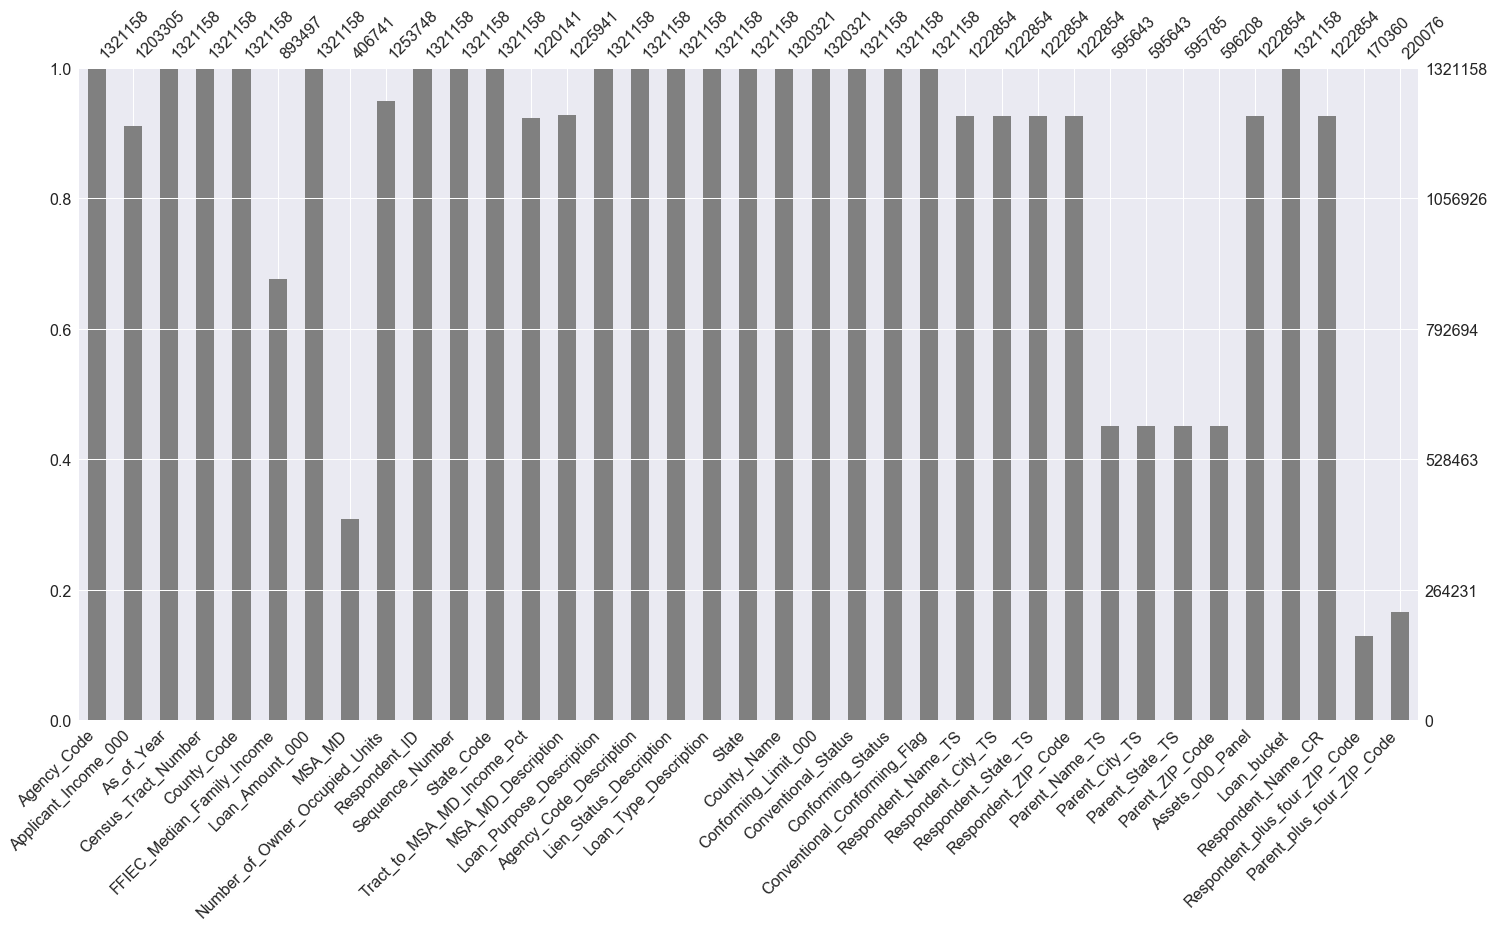

In [28]:
def reporting(df):
    print ('    Conventional_Conforming_Flag Attribute Validity Check Report')
    print (pd.DataFrame(df.groupby(['Conventional_Status','Conforming_Status','Conventional_Conforming_Flag']).size()))
    print ('')
    print ('                                         Data Completeness Report')
    print (msno.bar(df, color="gray", figsize=(24,12)))
reporting(final_data)

It is clear that all loan records follow the rules that only Conventional and Conforming loans are flagged Y in 'Conventional_Conforming_Flag'. Similar exercise should be performed for other important fields (for example no loan amount is less than zero) to ensure ease of analysis.


The bar chart above is a visualization of the data completeness. As MSA_MD, Census_Tract information and Parent institution information are missing for more than 50% of records, informing the strategy team should be careful while using them for the analysis.

# Part 3 Visual data narrative 

## a.Hypothesis to enter the market:

- 'Change Financial' should enter the purchase loans market in VA and MD for long term growth

### Criteria to validate the hypothesis
- There should be a relatively stable (preferably positive) Year over Year percentage change in the overall loan market volume/value.
- The market should have shown some indication of new competitors or smaller players improving their shares in the recent years.
- Regions of consideration should have good market size, which is defined as the loan volume and the total loan amount.

## b. Hypothesis Validation and Insights

#### Trend Analysis
First let us look at loan market volume and value trend by region:


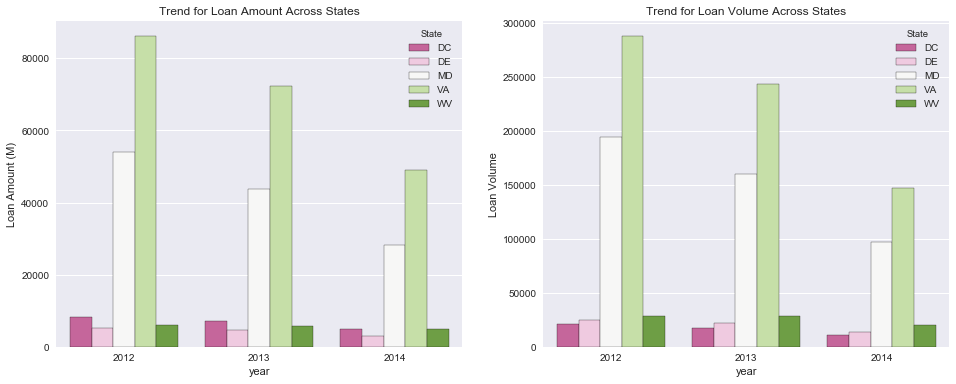

In [29]:
f, axes = plt.subplots(1, 2,figsize=(16, 6))

state_loan_value = final_data[['State', 'Loan_Amount_000','As_of_Year']]\
    .groupby(['State','As_of_Year'],as_index=False).sum()
state_loan_value['Loan_Amount_000'] = state_loan_value['Loan_Amount_000']/1000

state_loan_volume = final_data[['State', 'Loan_Amount_000','As_of_Year']]\
    .groupby(['State','As_of_Year'],as_index=False).count()

sns.barplot(x='As_of_Year', y='Loan_Amount_000',hue='State',palette="PiYG",data=state_loan_value,ax = axes[0],edgecolor='black')
sns.barplot(x='As_of_Year', y='Loan_Amount_000',hue='State',palette="PiYG",data=state_loan_volume,ax = axes[1],edgecolor='black')
axes[0].set(xlabel='year', ylabel='Loan Amount (M)',title = 'Trend for Loan Amount Across States')
axes[1].set(xlabel='year', ylabel='Loan Volume',title = 'Trend for Loan Volume Across States')

plt.show()

**Loan volume and value have been very high for states MD and VA over the years. However, both the Loan volume and loan amount are decreasing over the years across all states. The decrease is especially high for states MD and VA **

This decrease could be due to many reasons. Let us investigate different factors for further insights

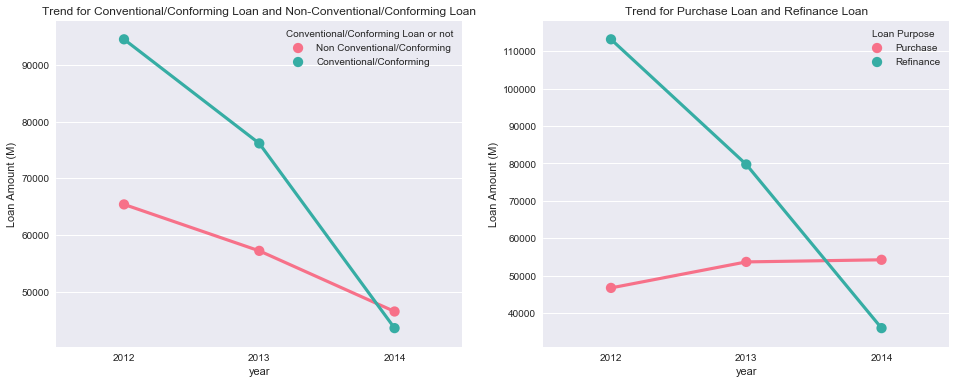

In [30]:
f, axes = plt.subplots(1, 2,figsize=(16,6))
Conventional_yn = final_data[['Conventional_Conforming_Flag', 'Loan_Amount_000','As_of_Year']]\
    .groupby(['Conventional_Conforming_Flag','As_of_Year'],as_index=False).sum()
Conventional_yn['Loan_Amount_000'] = Conventional_yn['Loan_Amount_000']/1000

Loan_Purpose = final_data[['Loan_Purpose_Description', 'Loan_Amount_000','As_of_Year']]\
    .groupby(['Loan_Purpose_Description','As_of_Year'],as_index=False).sum()
Loan_Purpose['Loan_Amount_000'] = Loan_Purpose['Loan_Amount_000']/1000
    

sns.pointplot(x='As_of_Year', y='Loan_Amount_000', hue='Conventional_Conforming_Flag',\
              palette="husl",data=Conventional_yn,ax= axes[0])
sns.pointplot(x='As_of_Year', y='Loan_Amount_000', hue='Loan_Purpose_Description',\
              palette="husl",data=Loan_Purpose,ax= axes[1])
axes[0].set(xlabel='year', ylabel='Loan Amount (M)',\
            title = 'Trend for Conventional/Conforming Loan and Non-Conventional/Conforming Loan')
axes[1].set(xlabel='year', ylabel='Loan Amount (M)',\
            title = 'Trend for Purchase Loan and Refinance Loan')

leg_handles = axes[0].get_legend_handles_labels()[0]
axes[0].legend(leg_handles, ['Non Conventional/Conforming', 'Conventional/Conforming'], \
               title='Conventional/Conforming Loan or not')

leg_handles2 = axes[1].get_legend_handles_labels()[0]
axes[1].legend(leg_handles2, ['Purchase','Refinance'], title='Loan Purpose')

plt.show()

The conventional and non conventional loans booked over time are both decreasing but it is the loan purpose, which has different trends. **The refinance loans are showing a 68% decrease in value from 2012 while the purchase loans are increasing. The volume of loans also shows a similar trend across purchase loans.This gives support to our first hypothesis validation criteria. Purchase loans has a positive Year over Year percentage change in the overall loan market volume/value.**

The decrease in refinance loans could be due to many reasons. One intuitive reason could be that the interest rates in the markets have increased and hence customers are not seeing much value in refinancing the loans. However, this cannot be concluded without interest rates.

Let us look at the respondents who are a part of this portfolio and their trends across time:

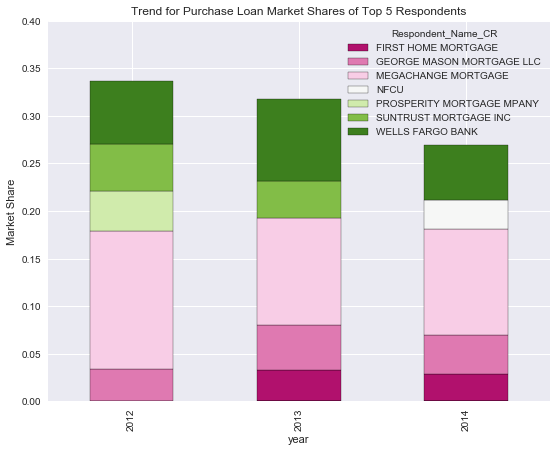

In [31]:
market_share_purchase=final_data\
                        [final_data['Loan_Purpose_Description']=='Purchase']\
                        [['Respondent_Name_CR', 'Loan_Amount_000','As_of_Year']]\
                        .groupby(['As_of_Year','Respondent_Name_CR']).sum()\
                        .groupby(level=[0]).transform(lambda x:x / float(x.sum())).reset_index()\
                        .groupby(['As_of_Year']).apply(lambda x: x.nlargest(5, 'Loan_Amount_000')).reset_index(drop=True)
                    
colors = sns.color_palette("PiYG", n_colors=len(market_share_purchase))
cmap1 = LinearSegmentedColormap.from_list("my_colormap", colors)
ax = market_share_purchase.groupby(['As_of_Year','Respondent_Name_CR'])['Loan_Amount_000']\
    .sum()\
    .unstack(level=1)\
    .plot.bar(stacked=True,figsize=(9,7),colormap=cmap1,ylim = (0,0.4),edgecolor='black')
    
ax.set(xlabel='year',ylabel='Market Share', title = 'Trend for Purchase Loan Market Shares of Top 5 Respondents')

*Only top 5 respondents are included in the above graph for clarity*

In terms of purchase loans, we can see that the 5 major banks are Megachange, Wells Fargo, First Home Mortgage, George Mason Mortgage and NFCU (in 2014). NFCU and First Home Mortgage market shares have been growing, whereas Prosperity Mortgage and Wells Fargo’s market shares are shrinking a little over the years in the purchase loans market.** This gives support to our second hypothesis validation criteria. The market should have shown some indication of new competitors or smaller players improving their market shares in the recent years.** Also, the top 5 major banks account for only 25%~35% total market share, which means the market is not dominated by few players.



#### Regional Analysis

First let us see market share for top 5 respondents by state:

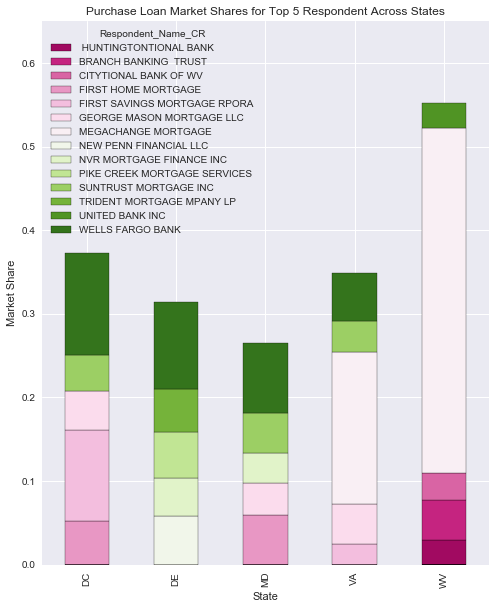

In [32]:
market_share_state=final_data\
                        [final_data['Loan_Purpose_Description']=='Purchase']\
                        [['Respondent_Name_CR', 'Loan_Amount_000','State']]\
                        .groupby(['State','Respondent_Name_CR']).sum()\
                        .groupby(level=[0]).transform(lambda x:x / float(x.sum())).reset_index()\
                        .groupby(['State']).apply(lambda x: x.nlargest(5, 'Loan_Amount_000')).reset_index(drop=True)

colors = sns.color_palette("PiYG", n_colors=len(market_share_state))
cmap1 = LinearSegmentedColormap.from_list("my_colormap", colors)
market_share_state = market_share_state\
    .groupby(['State','Respondent_Name_CR'])['Loan_Amount_000']\
    .sum()\
    .unstack(level=1)

ax = market_share_state.plot.bar(stacked=True,figsize=(8,10),colormap=cmap1,ylim = (0,0.65),edgecolor='black')
ax.set(xlabel='State', ylabel='Market Share',title = 'Purchase Loan Market Shares for Top 5 Respondent Across States')

There are no dominant players in MD and VA for purchase loans

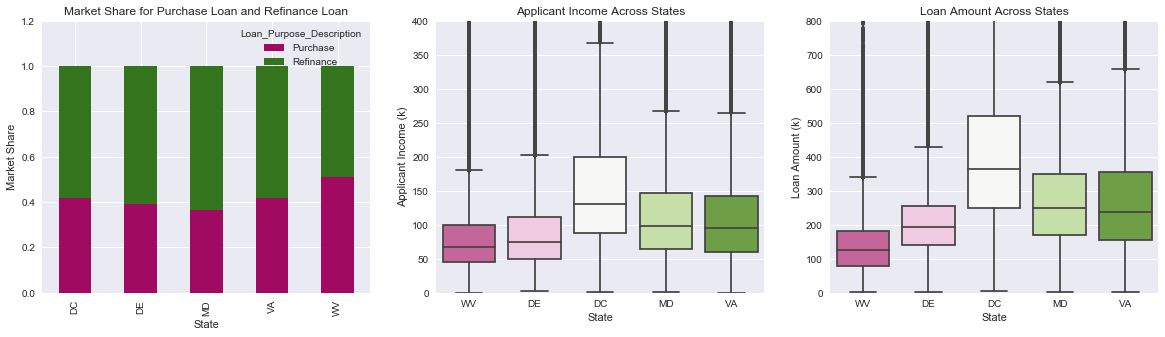

In [33]:
f, axes = plt.subplots(1, 3,figsize=(20, 5))

final_data.groupby(['State','Loan_Purpose_Description'])['Loan_Amount_000']\
    .sum()\
    .groupby(level=[0]).transform(lambda x:x / float(x.sum()))\
    .unstack(level=1).plot.bar(stacked=True,colormap=cmap1,ylim = (0,1.2),ax= axes[0])


sns.boxplot(x='State', y='Applicant_Income_000',data=final_data,palette="PiYG",ax= axes[1])
axes[1].set_ylim([0,400])

sns.boxplot(x='State', y='Loan_Amount_000',data=final_data,palette="PiYG",ax= axes[2]) #,palette="vlag")
axes[2].set_ylim([0,800])


axes[0].set(xlabel='State', ylabel='Market Share',\
            title = 'Market Share for Purchase Loan and Refinance Loan')
axes[1].set(xlabel='State', ylabel='Applicant Income (k)',\
            title = 'Applicant Income Across States')
axes[2].set(xlabel='State', ylabel='Loan Amount (k)',\
            title = 'Loan Amount Across States')


plt.show()

There is no significant difference/trends in market share by loan purpose, applicant income and loan amount in MD and VA compared to other states

## Draw conclusion from the analysis above:

- 'Change Financial' should enter the market for **purchase loans** in **MD** and **VA**. Reasons are:

    - Purchase loan market is less volatile market as compared to refinance loan market and there is a positive Year over Year percentage growth in the Purchase loan market value/volume.
    - The purchase loan market had smaller players such as NFCU growing across the years, indicating that there is potential for Change financial to enter the market by performing similar strategy.
    - MD and VA states have good market size.

However, additional information such as interest rates or more information across time period will help in further analysis. 

# Part 4 Bokeh interactive dashboard for competitor market share analysis

Inspired by Bokeh IMDB movie dashboard(https://demo.bokehplots.com/apps/movies), I decided to build a interactive dashboard in order to analyze 30 main competitors' performance in a given geography across the last 3 years. 

The dashboard has following features:
 - **Dot Size:** Represents market share for each competitor in the specific region and year
 - **X-axis:** Represents year 2012-2014
 - **Y-axis:** Can be changed by the dropdown on the left side and represents median loan, loan volume, total loan value accordingly
 - **Search Company Name:** Can be used to observe specific competitor (on the left side)
 - **Other filter:** Can use slider to filter specific competitors (on the left side)
 - **Hover:** Can highlight selected competitors and show information in detail
 
## Screen shot of the dashboard:

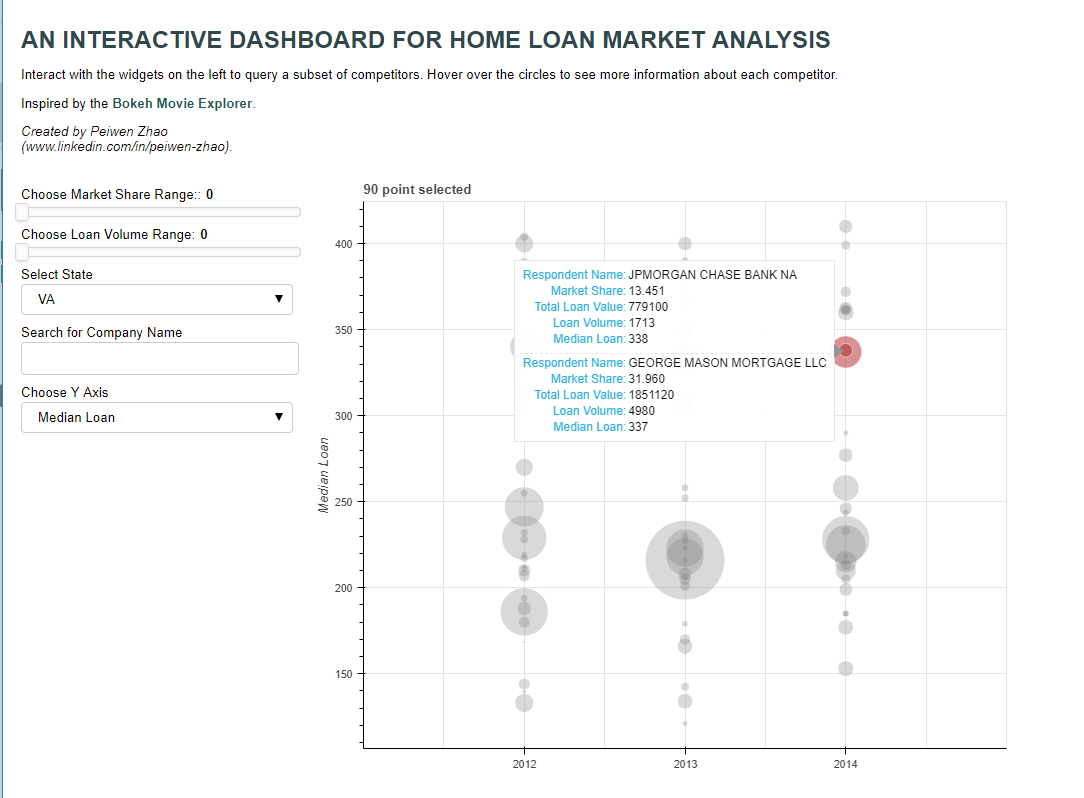

In [34]:
Image("dashboard.png")

## Data Preparation:

To build the dashboard, first I performed data munging to prepare competitor performance data that can be feed in the dashboard.

In [35]:
# Filter top 30 competitors
Top30_ALL = final_data[['Respondent_Name_CR', 'Loan_Amount_000']]\
                             .groupby('Respondent_Name_CR')['Loan_Amount_000']\
                             .sum() \
                             .reset_index(name='total_amount') \
                             .sort_values(['total_amount'], ascending=False) \
                             .head(31)
Top30_lst =Top30_ALL[Top30_ALL['Respondent_Name_CR']!='MEGACHANGE MORTGAGE']['Respondent_Name_CR'].tolist()

# Calculate market performance metrics
df1 = final_data.loc[final_data['Respondent_Name_CR']\
                               .isin(Top30_lst)][['Respondent_Name_CR', 'Loan_Amount_000','State','As_of_Year']]\
                               .groupby(['As_of_Year','Respondent_Name_CR','State'])\
                               .agg({'Loan_Amount_000':{'Median': np.median, 'Sum': np.sum,'Count':'count'}}).reset_index()
df1.columns = df1.columns.droplevel(0)
df1.columns = [ 'As_of_Year','Respondent_Name_CR','State','Count','Sum','Median']


df2 =  final_data.loc[final_data['Respondent_Name_CR']\
                               .isin(Top30_lst)][['Respondent_Name_CR', 'Loan_Amount_000','State','As_of_Year']]\
                               .groupby(['As_of_Year','State','Respondent_Name_CR']).agg({'Loan_Amount_000': 'sum'})\
                               .groupby(level=[0,1]).transform(lambda x:x / float(x.sum())).reset_index()
        
        
df_new = df1.merge(df2, how = 'inner', on = ['As_of_Year','State','Respondent_Name_CR'])\
        .rename(columns={"Loan_Amount_000": "Percentage"})

C:\Users\zhaop\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


## Show the dashboard through bokeh server:

The main code for the dashboard is stored seperately in folder 'Q4_dashboard'. We can access it through the code below:

In [ ]:
# While running the line below, a new page will open in browser showing the dashboard
!bokeh serve --show --port 9313 Q4_dashboard